In [1]:
import json
import graphviz
import csv
import numpy as np
import pandas as pd
import tifffile

## Purpose
This notebook is where I will try to make an annotation volume from a custom graph.
This is for using the graph structure saved in an interactive ontology session to load an annotated atlas voluem in Neuroglancer

In [2]:
atlas_dir = '/jukebox/LightSheetTransfer/atlas/allen_atlas/'
annotation_file_2017_16bit = atlas_dir + '/annotation_2017_25um_sagittal_forDVscans_16bit.tif' # Zahra made this
annotation_vol_16bit = tifffile.imread(annotation_file_2017_16bit)
xlsx_file = atlas_dir + '/allen_id_table_w_voxel_counts_16bit.xlsx'

test_ontology_file = 'test_ontology.json'
with open(test_ontology_file) as json_file:
    test_data = json.load(json_file)
    
ontology_file = 'allen_ontology_16bit_withrank.json'
with open(ontology_file) as json_file:
    data = json.load(json_file)
    
segments = np.unique(annotation_vol_16bit)

## Make list of region names that are displayed in default ontology

In [3]:
id_df = pd.read_excel(xlsx_file,index_col=None)
atl_ids_in_ann_n_tbl = [xx for xx in segments if xx in id_df["id"].values]
ids_in_ann_n_tbl = id_df[id_df["id"].isin(atl_ids_in_ann_n_tbl)]
displayed_atlas_regions_2017 = ids_in_ann_n_tbl["name"]

## Remaking ontology graph of a given rank
It will be useful to visualize the ontology graph with graphviz after I have collapsed the graph to a certain rank. Rather than remaking the JSON file, I should be able to use 

In [94]:
def make_vol_custom_graph(dic,graph,max_rank):
    """ 
    ---PURPOSE---
    Make ID
    Representing a brain ontology up a given max_rank 
    ---INPUT---
    dic       Dictionary representing the ontology graph (with "rank" key included)
    graph     The graphviz graph object that will be updated 
    max_rank  The rank up to which you want to show the ontology graph
    """
    name = dic.get('name')
    rank = dic.get('rank')
    label = name if len(name.split())<2 else '{0}\n{1}'.format(name.split()[0],' '.join(name.split()[1:])) # ternary operator 
    if name in displayed_atlas_regions_2017:
        graph.node(name,label,style='filled',fillcolor='yellow')
    else:
        graph.node(name,label)
    children = dic.get('children')
    for child in children:
        child_name = child.get('name')
        child_rank = child.get('rank')
        if child_rank > max_rank:
            continue
        graph.edge(name,child_name)
        make_graph_maxrank(child,graph,max_rank=max_rank)
    return

## Make dictionary linking parents at a given rank to all their children

In [121]:
def make_ID_reassignment_dict(ontology_dict,graph,output_dict):
    """ Loop through an ontology dictionary and return a dictionary 
    whose keys are parent ids at the highest level in the graph and values are a list
    of descendent ids of each of these parents. Here I operate on a new dictionary in which I have added the rank
    as a key to each region. "st_level" already existed but it is not continuous
    across the regions.
    """
    assert collapse_rank > 0, "You must use a collapse_rank > 0"
    name = ontology_dict.get('name')
    ID = ontology_dict.get('id')
    children = ontology_dict.get('children')
    graph_rank = ontology_dict.get('rank')

    if graph_rank == collapse_rank:
        output_dict[ID]=[]
        global current_parent
        current_parent = ID
    for child in children:
        child_ID = child.get('id')
        child_graph_rank = child.get('rank')
        if child_graph_rank > collapse_rank:
            output_dict[current_parent].append(child_ID)
        make_collapse_dict_postranking(child,collapse_rank,output_dict)
                
        
    return

Turns out that ranks 9 and above don't have any new information than the ranks below so start at rank=8.
The trick is to only use the graph dictionary up to a certain rank each time I make the new collapsed dict. Consider an example where I have make the rank 8 annotation volume and now I want to make the rank 7 annotation volume. I could get all the children of rank 7 at ranks 8 and above OR I could just use the annotation volume I created at rank 8 already then calculate the children of rank 7 at rank 8 only which will be much faster, especially as I get down lower in ranks because I won't be converting all of the grand-grand-grand children, for example. 
## Making dictionary only up to a certain rank

So I need a function that will return to me an ontology dictionary only up to a certain rank. I already have a function that will give me a graph up to a certain rank so I can just modify that one. 

In [105]:
def make_dict_maxrank(dic,max_rank):
    """ 
    ---PURPOSE---
    Take an input ontology dictionary and return an sub dictionary
    only up to a given max_rank
    ---INPUT---
    dic       Dictionary that you want to shorten representing the ontology
              graph (with "rank" key included)
    max_rank  The rank up to which you want to return the ontology dictionary
    """
#     name = dic.get('name')
    rank = dic.get('rank')
    children = dic.get('children')
    if rank == max_rank:
        dic['children']=[]
        return
    for child in children:
#         child_name = child.get('name')
        make_dict_maxrank(child,max_rank=max_rank)
    return

In [106]:
new_dict = data.copy()
make_dict_maxrank(new_dict,max_rank=2)

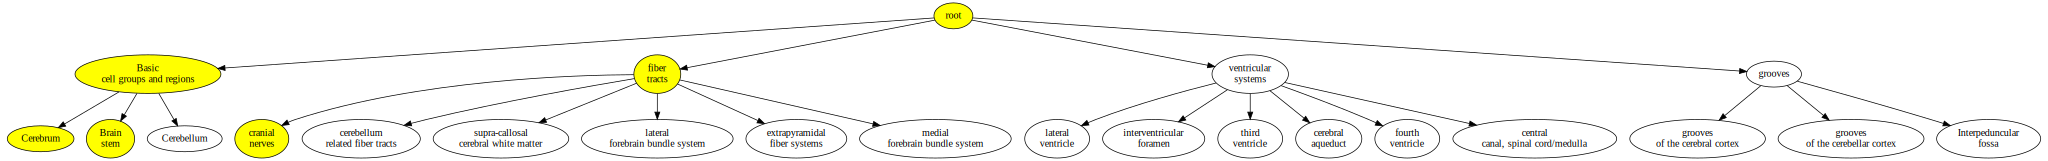

In [114]:
# test that it worked
G = graphviz.Digraph()
make_graph_maxrank(new_dict,G,max_rank=3)
G

## Creating annotation volumes up to lower ranks
I already know that rank 9 and greater have no more information than the lower ranks so start at rank 8.

The idea is to make a new annotation volume at each rank and then update the dictionary so that I'm only having to change the ids of the next lowest rank rather than all of the children and grandchildren, etc.

First let's define a function which actually assigns the IDs of the children to their parents

In [118]:
def ID_reassignment(annotation_volume,collapse_dict):
    """
    ---PURPOSE---
    Assign child ids to parent ids in collapse_dict within an annotation volume
    """
    for parent_id in collapse_dict.keys():
        child_ids = collapse_dict[parent_id]
        for child_id in child_ids:
            mask = annotation_volume == child_id
            annotation_volume[mask] = parent_id

In [135]:
def make_subrank_annotation_volumes(annotation_vol,ontology_dict):
    """
    ---PURPOSE---
    Make each of the lower rank atlas annotation volumes.
    WARNING - this function updates in place the annotation_vol 
    and ontology_dict that are given as inputs. Provide copies 
    of data if you do not want to overwrite them.
    ---INPUT---
    annotation_vol    The starting annotation volume (of highest rank)
    ontology_dict     The starting ontology dictionary (of highest rank)
    """
    for rank in [9,8,7,6,5,4,3,2,1]:
        print("Working on rank=%i" % rank)
        ID_assignment_dict = {}
        make_ID_reassignment_dict(ontology_dict=ontology_dict,collapse_rank=rank,\
                                       output_dict=ID_assignment_dict) # updates output_dict
        ID_reassignment(annotation_vol,ID_assignment_dict) # updates annotation volume for next loop
        # Save the annotation volume
        savename = '/home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank%i.tif' % rank
        tifffile.imsave(savename,annotation_vol)
        print("Saved ", savename)
        # Reassign ontology_dict to the next lowest rank for next loop
        make_dict_maxrank(dic=ontology_dict,max_rank=rank)
        
        

In [136]:
vol = annotation_vol_16bit.copy()
ontology_dict = data.copy()
make_subrank_annotation_volumes(annotation_vol=vol,ontology_dict=ontology_dict)

Working on rank=9
Saved  /home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank9.tif
Working on rank=8
Saved  /home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank8.tif
Working on rank=7
Saved  /home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank7.tif
Working on rank=6
Saved  /home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank6.tif
Working on rank=5
Saved  /home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank5.tif
Working on rank=4
Saved  /home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank4.tif
Working on rank=3
Saved  /home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank3.tif
Working on rank=2
Saved  /home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank2.tif
Working on rank=1
Saved  /home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank1.tif


In [137]:
rank6_vol = tifffile.imread('/home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank6.tif')

In [138]:
rank6_segments = np.unique(rank6_vol)

In [139]:
rank6_segments

array([    0,     6,     7,    10,    12,    17,    22,    23,    26,
          30,    31,    35,    38,    42,    44,    50,    51,    54,
          56,    58,    62,    63,    66,    67,    72,    75,    78,
          81,    83,    88,    91,    93,    95,    98,   100,   102,
         106,   108,   115,   117,   118,   125,   126,   128,   129,
         131,   133,   135,   136,   138,   140,   145,   146,   147,
         151,   153,   154,   158,   159,   162,   164,   173,   184,
         190,   194,   197,   198,   203,   206,   207,   214,   215,
         222,   223,   226,   229,   230,   231,   235,   237,   238,
         239,   242,   246,   247,   254,   262,   263,   271,   272,
         280,   286,   287,   292,   298,   301,   303,   307,   310,
         311,   313,   318,   326,   327,   331,   332,   333,   334,
         336,   338,   342,   347,   349,   350,   351,   354,   356,
         358,   364,   372,   374,   380,   381,   390,   395,   397,
         398,   403,

In [141]:
rank5_vol = tifffile.imread('/home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank5.tif')

In [142]:
rank5_segments = np.unique(rank5_vol) 

In [143]:
rank5_segments

array([    0,     4,     6,    35,    54,    58,    62,    66,    75,
          78,    81,    91,    93,    98,   102,   108,   115,   117,
         125,   128,   129,   131,   140,   141,   145,   153,   157,
         158,   164,   165,   190,   198,   214,   229,   231,   237,
         246,   271,   275,   278,   290,   294,   295,   301,   302,
         313,   315,   319,   326,   336,   349,   354,   370,   374,
         379,   381,   386,   397,   413,   460,   466,   467,   477,
         482,   485,   493,   506,   512,   514,   530,   538,   549,
         553,   579,   580,   583,   595,   603,   611,   616,   618,
         633,   658,   665,   673,   681,   690,   697,   698,   703,
         728,   737,   744,   749,   753,   757,   771,   780,   784,
         794,   795,   798,   802,   803,   809,   812,   818,   826,
         832,   835,   841,   846,   848,   850,   856,   863,   864,
         866,   874,   884,   900,   908,   911,   912,   916,   920,
         924,   928,

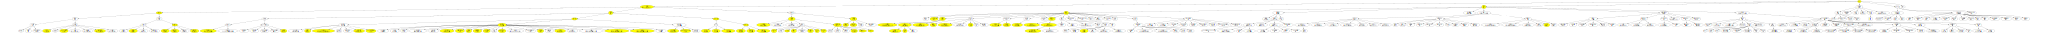

In [149]:
G = graphviz.Digraph()
make_graph_maxrank(data,G,max_rank=5)
G

In [91]:
tifffile.imsave(file='/home/ahoag/ngdemo/graphviz/annotation_2017_25um_sagittal_16bit_rank8.tif',data=copied_vol)